<a href="https://colab.research.google.com/github/giovannimmiranda/DL_20-06_GMM/blob/main/DL_20_06_Miranda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Exam - 20/06/2024**


## Giovanni Michele Miranda,  507567

*DISCLAIMER* : In **bold text** are identified those elements explicitated during the text exam.

# General Information
We are given a dataset containing 186 images which are categorized into three classes, depending on the main object they contain. The following inputs are available:
1. input image, a 227 × 227 × 3 real-valued tensor. The last dimension denotes the number of input channels (RGB). Each pixel is a value in [0, 255];
2. image label, integer in the set {1,2,3} denoting one of three possible objects an image can contain. There are 63, 62, and 61 images belonging to the class 1, 2 and 3, respectively;
3. image bounding box, four integers x1, y1, x2, y2 in the range 1–227, where (x1, y1) and (x2, y2) are the bottom-left and the top-right corners of the box containing the object, respectively.

**TASK**: Design a deep neural network model to predict the class of an image along with the corresponding bounding box coordinates.

# 1) Type of tasks
The requirements induce us to implement two different types of task:


1.   **Multiclass Classification**: we are required to predict the exact class of an image among the three of the proposed dataset.
2.   **Regression**: we are required to predict the exact bounding box coordinate values, which also come along with the images. In simple terms, we need to predict the box with the smallest measure within which all the points of the reference image lie.



## Architecture Proposed
The idea that came to mind is to use a convolutional neural network (**CNN**) as the reference model. CNNs are well-known for their ability to handle spatial relationships and features within images, such as edges and borders.
More deeper insights about the created model will be given later in the specific sections.

# 2) Input

**Import libraries**: In this section as first I will import the libraries needed later for the construction and operational tasks of the architecture


In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

**Import Data**: In the second step, I import the dataset using the code provided by the professor on the course's webpage.

In [48]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/giovannimmiranda/DL_20-06_GMM/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
  data = pk.load(f)
images = data['imgs']
y = data['labels']
labels = y[:,0]
bboxes = y[:,1:]

The dataset consists of three inputs that need to be preprocessed to ensure they have the correct *shape* for the architecture to properly process and utilize them.

**Pixel Normalization**: As first normalization step, I have normalized images pixels from former [0,255] interval into the **bounded interval [0,1]**. This process ensures a faster convergence and prevent (at least as very first step) large gradients.

This is done by subtracting the minimum pixel value from each pixel and then divide by the range (maximum pixel value **-** minimium pixel value).

In [50]:
images = (images - np.min(images)) / (np.max(images) - np.min(images))

**Image Balancing**: In my implementation I have suggested to equally balance the number of images in the three classes of the dataset. In fact our dataset was proposed with:

*   Class 1: 63 images
*   Class 2: 62 images
*   Class 3: 61 images.

My goal is to balance them all, by removing randomly and respectively two and one images for class 1 and class 2.

In [52]:
label_to_remove_c1 = 1  # First class
label_to_remove_c2 = 2  # Second class

# Here we check that there are enough images in the set
if labels.shape[0] > 184 and images.shape[0] > 184:
    # Find indices of images with the specified labels
    indices_to_remove_c1 = np.where(labels == label_to_remove_c1)[0]
    indices_to_remove_c2 = np.where(labels == label_to_remove_c2)[0]

    # Randomly select two indices from the first class
    random_indices_c1 = random.sample(list(indices_to_remove_c1), 2)
    # Randomly select one index from the second class
    random_indices_c2 = random.sample(list(indices_to_remove_c2), 1)

    # Remove the selected images and their corresponding labels
    images = np.delete(images, random_indices_c1, axis=0)
    labels = np.delete(labels, random_indices_c1, axis=0)
    # Adjust the second class index due to the removal of the first class indices
    random_indices_c2 = [i - np.sum(random_indices_c1 < i) for i in random_indices_c2]
    images = np.delete(images, random_indices_c2, axis=0)
    labels = np.delete(labels, random_indices_c2, axis=0)

    print(f"Removed images at indices: {random_indices_c1} from class 1 and {random_indices_c2} from class 2")
    print(f"New dataset size: {images.shape[0]} images, {labels.shape[0]} labels")
else:
    print(f"The dataset is already set! It has {images.shape[0]} images.")
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nNow the dataset is balanced:")
    for label, count in zip(unique_labels, counts):
      print(f"\n Class {label}: {count} images")

Removed images at indices: [43, 40] from class 1 and [107] from class 2
New dataset size: 183 images, 183 labels


In [51]:
images.shape

(186, 227, 227, 3)

In [6]:
batch_size = 5
bboxes[:batch_size]

array([[ 23,  42, 206, 199],
       [ 13,  70, 219, 160],
       [  8,  42, 221, 200],
       [ 22,  67, 218, 158],
       [ 15,  56, 212, 156]])

**Bounding Box Normalization**: In the following cell, I want to normalize bounding boxes in a fixed bound [0,1], for a similar reason as for image pixels, very large values can indeed create problems with gradients.

The normalization addresses this problem and is basically harmless, since at the end of the training process we can restore the original sizes and correctly visualizes the boxes along with the images.

In [7]:
image_width_height = 227

# Bounding Boxes can be thought of like (x1, y1, x2, y2).
bboxes_normalized = bboxes.astype(float)
bboxes_normalized[:, 0] /= image_width_height  # Normalize x1
bboxes_normalized[:, 1] /= image_width_height  # Normalize y1
bboxes_normalized[:, 2] /= image_width_height  # Normalize x2
bboxes_normalized[:, 3] /= image_width_height  # Normalize y2

print(f"Printing first {batch_size} normalized bounding boxes:")
print(bboxes_normalized[:batch_size])

#Removing images at indices [47, 36] from class 1 (chosen at random) and [115] (chosen at random) from class 2
removed_indices = [47, 36, 115]

# Remove corresponding bounding boxes
bboxes_normalized = np.delete(bboxes_normalized, removed_indices, axis=0)

# Now `bboxes_normalized` contains the updated bounding box data after removal
print("Updated number of bounding boxes:", len(bboxes_normalized))
print(bboxes_normalized.shape)

Printing first 5 normalized bounding boxes:
[[0.10132159 0.18502203 0.90748899 0.87665198]
 [0.05726872 0.30837004 0.96475771 0.70484581]
 [0.03524229 0.18502203 0.97356828 0.88105727]
 [0.0969163  0.29515419 0.96035242 0.69603524]
 [0.0660793  0.24669604 0.9339207  0.68722467]]
Updated number of bounding boxes: 183
(183, 4)


*Note* : This process was not included in the exam because it emerged later due to the requirements imposed by the classification loss function module.


**Labels reshaping**: Here I add an additional processing step, which brings the adjustement of the labels interval from [1,3] to [0,2]. This choice is forced by the sparse categorical cross entropy (our classification loss), which
just operates with labels within that ranges (starting from 0).

In [8]:
labels = labels - 1

Now the input is set for all those operations required for the training section.

##Dataset Preparation
The code begins by splitting the dataset into training and validation sets using train_test_split. It divides the images, classification labels, and normalized bounding boxes, with 20% of the data reserved for validation. The random state is set to 42 for reproducibility.

In [9]:
X_train, X_val, y_train_cls, y_val_cls, y_train_bbox, y_val_bbox = train_test_split(images, labels, bboxes_normalized, test_size=0.2, random_state=42)

# 3-4-5) Architecture

##Residual Block Definition
The code defines a function for a **residual block**, which includes **convolutional layers** with **L2 regularization**, **batch normalization**, and **ReLU** activation functions. The residual block also includes a shortcut connection to add the input to the output, ensuring gradient flow during training.

Additionally, I implemented a seed (random integer) in **weight initialization He Uniform** to ensure reproducibility by generating the same random numbers each time the model is created. This choice allows for a controlled comparison between models with different hyperparameters, ensuring that performance differences are due to these changes rather than random variations in weight initialization.

In [23]:
seed = random.randint(0, 1000)

def residual_block(x, filters, num_conv_layers=3, kernel_size=3, stride=1, l2_reg=0.001):
    shortcut = x
    initializer = tf.keras.initializers.HeUniform(seed=seed)

    for _ in range(num_conv_layers):
        x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                                   kernel_initializer=initializer)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)

    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                          kernel_initializer=initializer)(shortcut)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

Below we can see a visualization created for my Residual Block.

*note: the code used to create it has been suppressed for visualization purposes.*

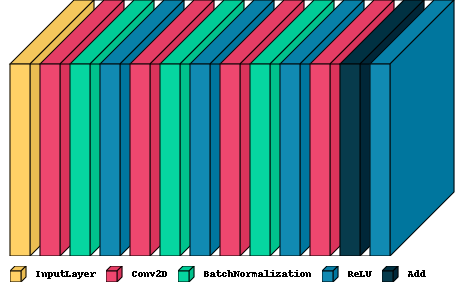

##Model Pipeline
The model architecture *(my_model)* is defined with an input layer corresponding to the shape of the training images. The input is passed through a series of residual blocks with increasing **filter sizes** and **max pooling layers** to reduce the spatial dimensions. The final features are flattened and passed through a dense layer with L2 and weight regularization, which will perform higher-level reasoning on the output of the convolution.

###Output Layers
The model has two output branches:

*   **Classification Branch**:
    * *outputs_cls* : A dense layer with num_classes neurons for classification with a softmax activation function (so-called SoftMax Layer).

*   **Regression Branch**:
    * *reg_branch* : Two dense layers with ReLU activation for the regression task.
    * *outputs_reg* : A dense layer with 4 neurons for predicting bounding box coordinates (x1, y1, x2, y2), along with a linear activation function (simple MLP).

### Model Compilation
The model is compiled with the **Adam** optimizer, which includes **gradient clipping** to prevent exploding gradients.
It uses **sparse_categorical_crossentropy** loss for the classification output (labels are integers) and **mean_squared_error** loss for the regression output (usual choice). The metrics tracked in this phase are accuracy for classification and mean squared error for regression.
Later, we will see deeper evaluation analysis.

In [56]:
num_classes = 3 #number of classes for the classification
input_shape = [images.shape[1], images.shape[2], images.shape[3]]

def my_model(input_shape, num_classes, learning_rate=0.001, hidden_activation='relu', l2_reg=0.001,
             num_conv_layers_per_block=4, num_pooling=2, filter_dim=(3, 3), batch_size=16, padding='same'):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    filters = 16
    for _ in range(num_pooling):  # Fixed number of residual blocks to 4
        x = residual_block(x, filters, num_conv_layers=num_conv_layers_per_block, l2_reg=l2_reg)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        filters *= 2  # Double the number of filters with each block

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation=hidden_activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(x)

    # Classification branch
    outputs_cls = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_output')(x)

    # Regression branch
    reg_branch = tf.keras.layers.Dense(128, activation='relu')(x)
    reg_branch = tf.keras.layers.Dense(64, activation='relu')(reg_branch)
    outputs_reg = tf.keras.layers.Dense(4, activation='linear', name='regression_output')(reg_branch)

    # Define the model with multiple outputs
    model = tf.keras.Model(inputs=inputs, outputs=[outputs_cls, outputs_reg])

    # Compile the model with separate loss functions for each output
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=0.5)
    model.compile(optimizer=optimizer,
                  loss={'classification_output': 'sparse_categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                  metrics={'classification_output': 'accuracy', 'regression_output': 'mse'})
    return model

##Model Training
I have then implemented a parameter grid by defining the main parameters for tuning (among those listed in the written test):
  * **Learning rate**
  * **Number of convolutional layers** for each redisual block
  * **Number of Pooling Layers**
  * **Filter size**
  * **Batch size**

The model is trained for 10 epochs each iter (it would have been more, but the choice is made for computational reasons) with early stopping based on validation loss, which halts training if the validation loss does not improve for three consecutive epochs. Early stopping also restores the best weights observed during training.



In [57]:
param_grid = {
    'learning_rate': [10**-4, 10**-3],
    'num_conv_layers_per_block': [3, 4, 5],  # Number of convolutional layers per residual block
    'num_pooling': [2, 3],
    'filter_dim': [(3, 3), (5, 5)],  # Dimensions of convolutional filters
    'batch_size': [8, 16],
}


def random_search_multitask(X_train, X_val, y_train_cls, y_val_cls, y_train_bbox, y_val_bbox, param_grid, iter=5, epochs=10, batch_size=8):
    best_score = 0
    best_model = None
    results = []

    for _ in range(iter):
        params = {key: random.choice(value) for key, value in param_grid.items()}
        print(f"Training model with params: {params}")

        model = my_model(X_train.shape[1:], num_classes=num_classes, **params)

        history = model.fit(X_train, {'classification_output': y_train_cls, 'regression_output': y_train_bbox},
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, {'classification_output': y_val_cls, 'regression_output': y_val_bbox}),
                            verbose=1)

        # Evaluate on validation data
        losses = model.evaluate(X_val, {'classification_output': y_val_cls, 'regression_output': y_val_bbox}, verbose=0)
        classification_loss = losses[1]
        regression_loss = losses[2]

        y_pred_cls = np.argmax(model.predict(X_val)[0], axis=1)
        accuracy = accuracy_score(y_val_cls, y_pred_cls)
        f1 = f1_score(y_val_cls, y_pred_cls, average='weighted')

        mse = mean_squared_error(y_val_bbox, model.predict(X_val)[1])

        results.append({
            'params': params,
            'classification_loss': classification_loss,
            'regression_loss': regression_loss,
            'accuracy': accuracy,
            'f1_score': f1,
            'mse': mse,
        })

        if accuracy > best_score:
            best_score = accuracy
            best_model = model

    return results, best_model

# 6) Model Evaluation
Finally, the model is evaluated on the validation set, and the classification and regression losses are printed. This evaluation helps to understand the model's performance on unseen data.

In [58]:
best_model, results = random_search_multitask(X_train, X_val, y_train_cls, y_val_cls, y_train_bbox, y_val_bbox, param_grid)

# Results
for result in results:
    print(f"Params: {result['params']}")
    print(f"Classification Loss: {result['classification_loss']:.4f}, Regression Loss: {result['regression_loss']:.4f}")
    print(f"Accuracy: {result['accuracy']:.4f}, F1 Score: {result['f1_score']:.4f}, MSE: {result['mse']:.4f}")
    print("\n")

Training model with params: {'learning_rate': 0.001, 'num_conv_layers_per_block': 3, 'num_pooling': 3, 'filter_dim': (3, 3), 'batch_size': 16}
Epoch 1/10
19/19 [==============================] - 9s 72ms/step - loss: 2111.9678 - classification_output_loss: 83.9469 - regression_output_loss: 2027.1316 - classification_output_accuracy: 0.3630 - regression_output_mse: 2027.1316 - val_loss: 469.4927 - val_classification_output_loss: 34.2389 - val_regression_output_loss: 434.1559 - val_classification_output_accuracy: 0.2162 - val_regression_output_mse: 434.1559
Epoch 2/10
19/19 [==============================] - 1s 49ms/step - loss: 129.3316 - classification_output_loss: 46.5709 - regression_output_loss: 81.5774 - classification_output_accuracy: 0.3288 - regression_output_mse: 81.5774 - val_loss: 584.9349 - val_classification_output_loss: 56.9584 - val_regression_output_loss: 526.7318 - val_classification_output_accuracy: 0.2973 - val_regression_output_mse: 526.7318
Epoch 3/10
19/19 [========

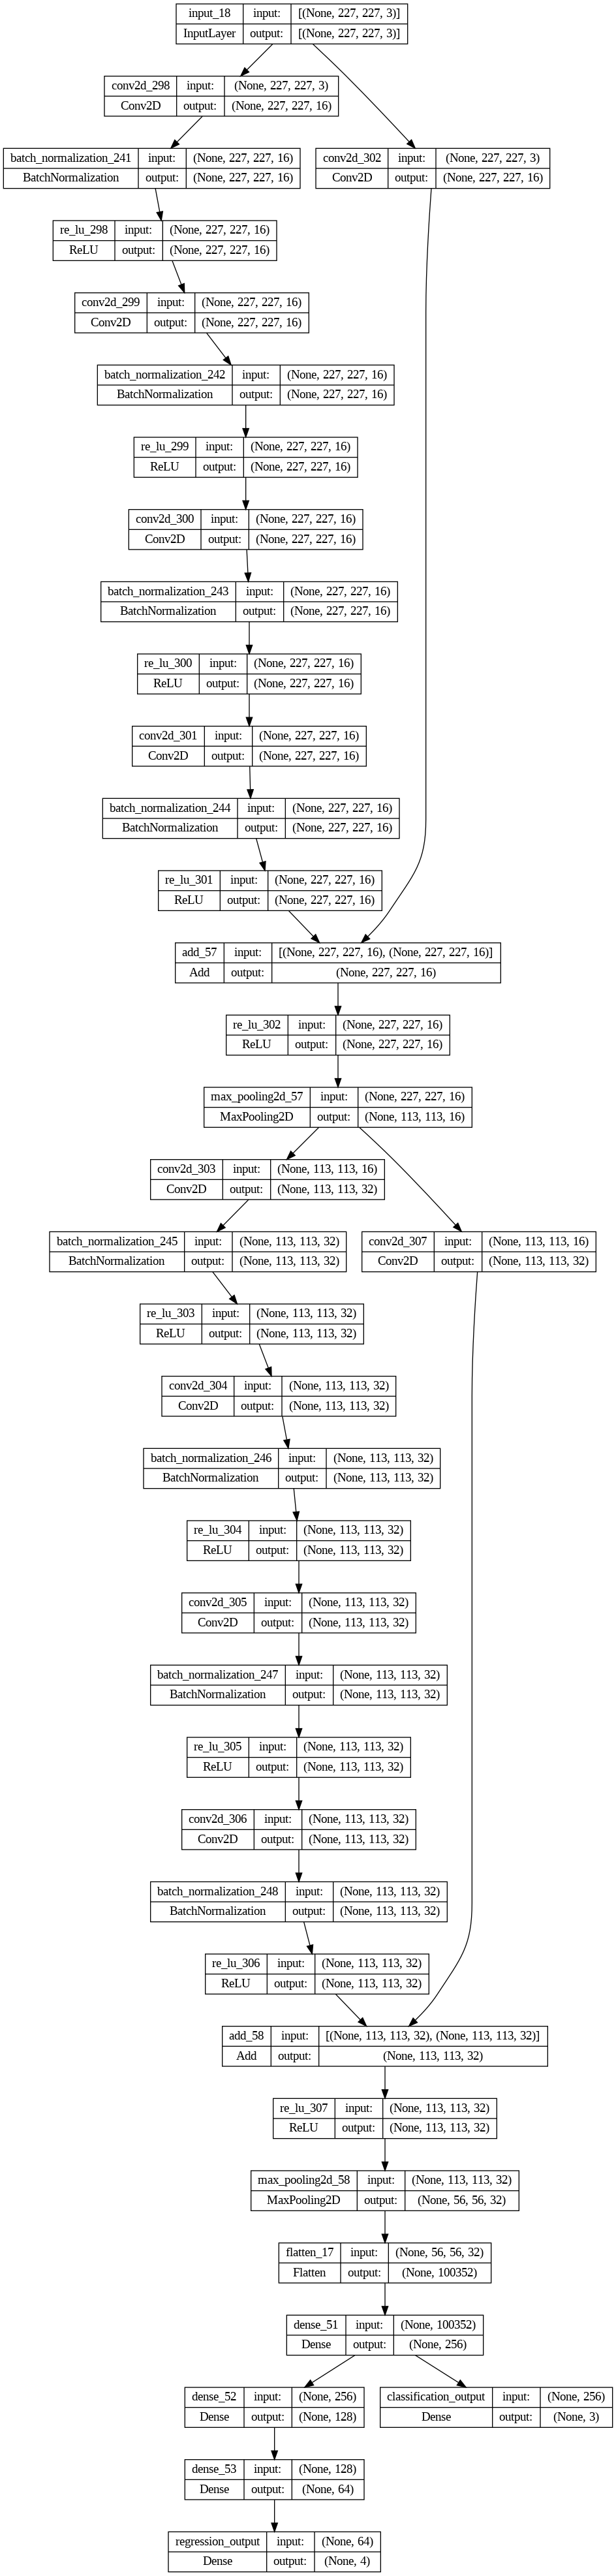

In [63]:
plot_model(best_model, show_shapes=True, show_layer_names=True)

In the following cell, I aim to print the best scores achieved by my model in terms of **Accuracy**, **F1-Score** and **MSE**. Additionally, I will print the best model configuration for each of these metrics. Often, the best results for both accuracy and MSE come from the same configuration. By examining the configuration differences, we can identify areas for tuning and improvement to potentially achieve the best overall results.

In [74]:
best_accuracy = -float('inf')
best_mse = float('inf')
best_f1 = -float('inf')
best_model_config = None
best_mse_model_config = None

for result in results:
    accuracy = result['accuracy']
    mse = result['mse']
    f1 = result['f1_score']

    # Update best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_config = result['params']

    # Update best MSE corresponding to the best accuracy
    if accuracy == best_accuracy and mse < best_mse:
        best_mse = mse
        best_mse_model_config = result['params']

    if accuracy == best_accuracy and mse == best_mse and f1 > result['f1_score']:
        best_model_config = result['params']

print("Best Accuracy:", best_accuracy)
print("Best MSE:", best_mse)
print("Best F1-Score",)
print("Best model configuration for Accuracy and F1-Score:", best_model_config)
print("Best model configuration for MSE:", best_mse_model_config)


Best Combined Score: 0.8404025502164373
Best Accuracy: 0.7837837837837838
Best MSE: 0.06931617021531891
Best model configuration: {'learning_rate': 0.0001, 'num_conv_layers_per_block': 4, 'num_pooling': 3, 'filter_dim': (3, 3), 'batch_size': 16}


In this final cell, we plot a small batch of images to visually assess the classification performance.

Note: For the regression part, although it is not shown here but it has been expressed in the test, the bounding box values need to be transformed back to their original dimensions (restored to the range [0, 255]) for effective visualization over the corresponding images.

2/2 [==============================] - 0s 57ms/step


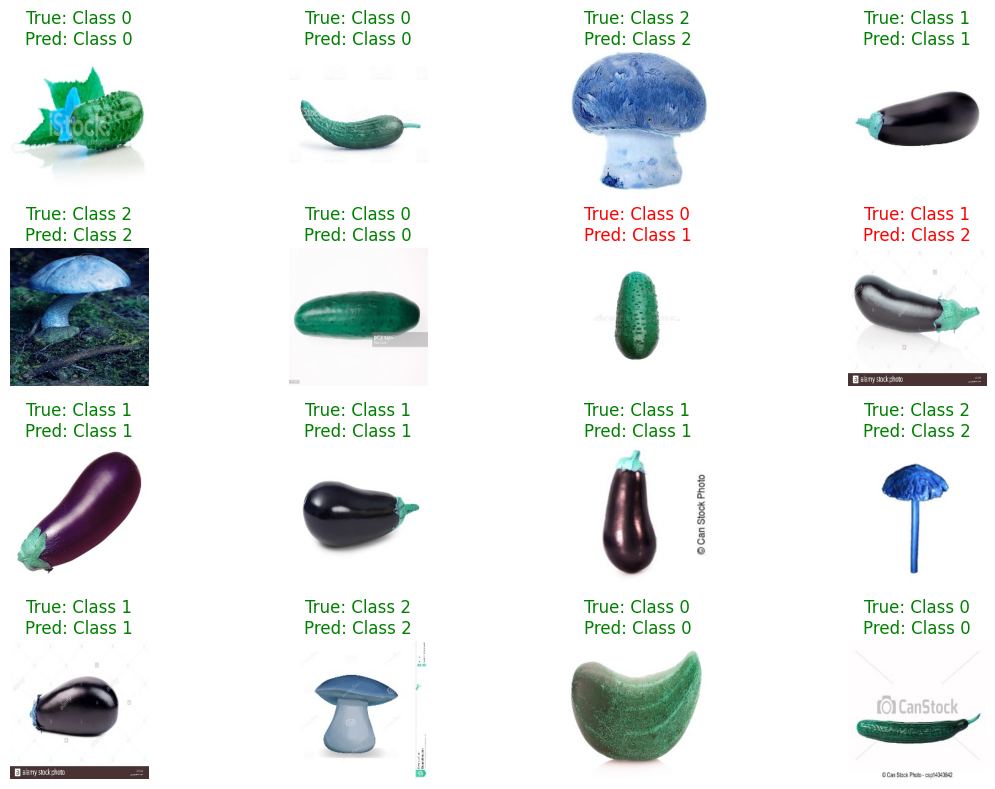

In [61]:
# Function to plot images with their predicted and true labels
def plot_images_with_labels(images, true_labels, pred_labels, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f'True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}', color='green' if true_labels[i] == pred_labels[i] else 'red')
    plt.tight_layout()
    plt.show()

# Get predicted class labels (softmax output, take argmax)
predictions = best_model.predict(X_val)  # Get predictions for both outputs
predicted_labels = np.argmax(predictions[0], axis=1)  # Apply argmax to classification output

# List of class
classes = ['Class 0', 'Class 1', 'Class 2']

# Visualize a sample of validation images with their predicted and true labels
sample_images = X_val[:16]  # Adjust number of images to plot
sample_true_labels = y_val_cls[:16]  # True labels from validation set
sample_pred_labels = predicted_labels[:16]  # Predicted labels from model

plot_images_with_labels(sample_images, sample_true_labels, sample_pred_labels, classes)